In [72]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [73]:
df_1 = pl.read_parquet('data/male_formal_1.parquet')
df_2 = pl.read_parquet('data/male_formal_2.parquet')

In [74]:
df_3 = pl.read_parquet('data/male_informal_1.parquet')
df_4 = pl.read_parquet('data/male_informal_2.parquet')

In [75]:
n_au = 27 # Nr of action units

# Reference ids of the action units
au_ref = [1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22,
          23, 24, 25, 26, 27, 32, 38, 39]

def extract_au(df):
    features = df.select(
        [   
            'time',
            'frame',
            'face_prob',
            pl.lit([list(range(n_au))]).alias("face_au"),
            pl.col("face_aus").alias("value").list.take(list(range(n_au)))
        ]
    ).filter(pl.col("value").is_not_null()).explode(["face_au", "value"])

    return features.to_pandas()
    
features_1 = extract_au(df_1)
features_2 = extract_au(df_2)
#features_3 = extract_au(df_3)
#features_4 = extract_au(df_4)

# Label the action units with the reference ids
# features_1['face_au'] = features_1['face_au'].apply(lambda x: au_ref[x])
# features_2['face_au'] = features_2['face_au'].apply(lambda x: au_ref[x])

/var/folders/jh/mjfcxr_509gc9z3gd91thc0w0000gn/T/ipykernel_35281/3392904044.py:13: DeprecationWarning: Behavior for `lit` will change for sequence inputs. The result will change to be a literal of type List. To retain the old behavior, pass a Series instead, e.g. `Series(sequence)`.
  pl.lit([list(range(n_au))]).alias("face_au"),
/var/folders/jh/mjfcxr_509gc9z3gd91thc0w0000gn/T/ipykernel_35281/3392904044.py:13: DeprecationWarning: Behavior for `lit` will change for sequence inputs. The result will change to be a literal of type List. To retain the old behavior, pass a Series instead, e.g. `Series(sequence)`.
  pl.lit([list(range(n_au))]).alias("face_au"),


In [76]:
features_1 = features_1[features_1['face_prob'] > 0.9].drop(columns=['face_prob'])
features_2 = features_2[features_2['face_prob'] > 0.9].drop(columns=['face_prob'])

In [77]:
def mean_activation(df):
    mean = df.groupby('face_au')['value'].mean()
    return mean

mean_1 = mean_activation(features_1)
mean_2 = mean_activation(features_2)

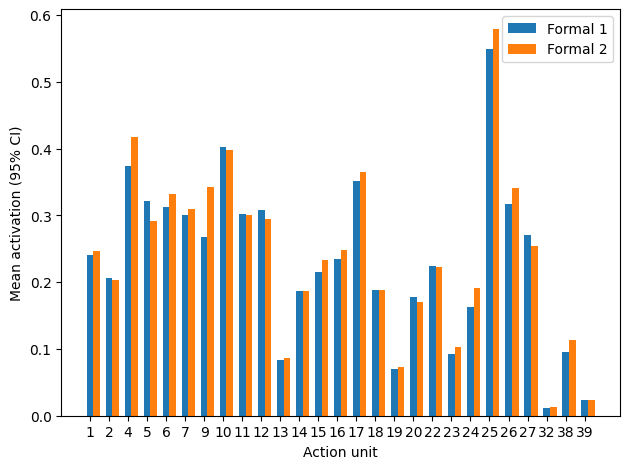

In [78]:
# Plot the mean activation of each action unit

aus = np.arange(n_au)

fig, ax = plt.subplots()
ax.bar(mean_1.index, mean_1.values, 0.35, label='Formal 1')
ax.bar(mean_2.index + 0.35, mean_2.values, 0.35, label='Formal 2')

ax.set_xlabel('Action unit')
ax.set_xticks(aus, au_ref)
ax.set_ylabel('Mean activation (95% CI)')
ax.legend()

fig.tight_layout()

plt.show()

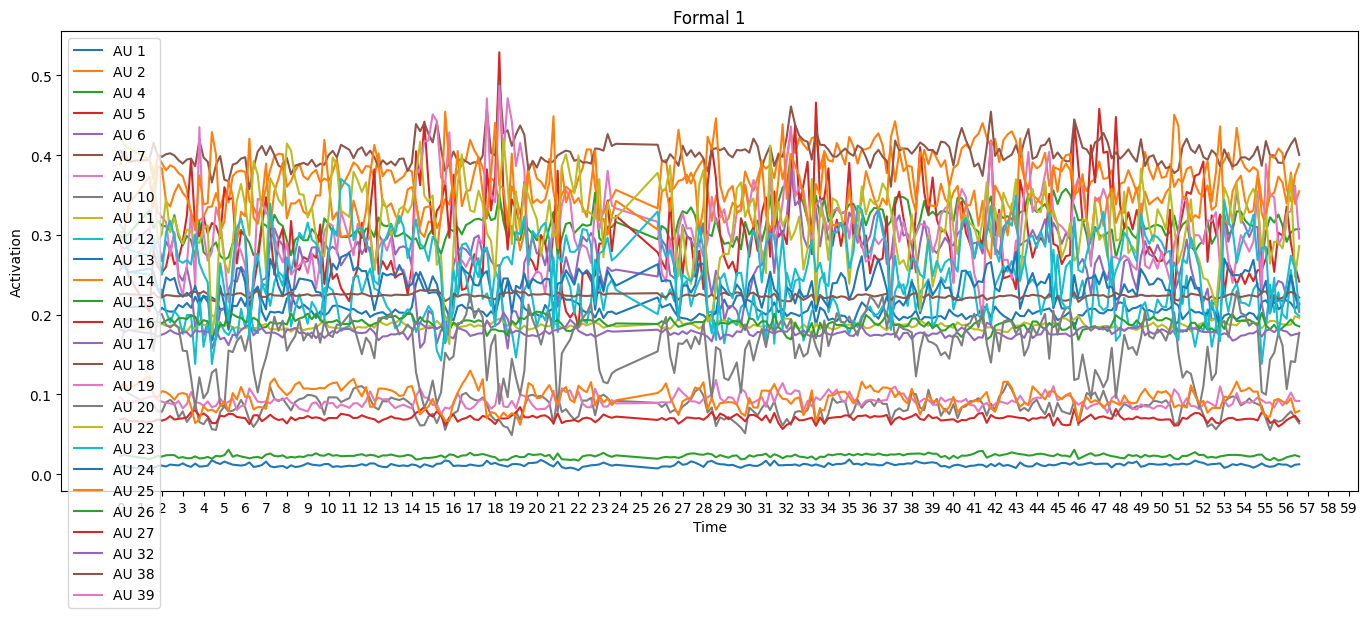

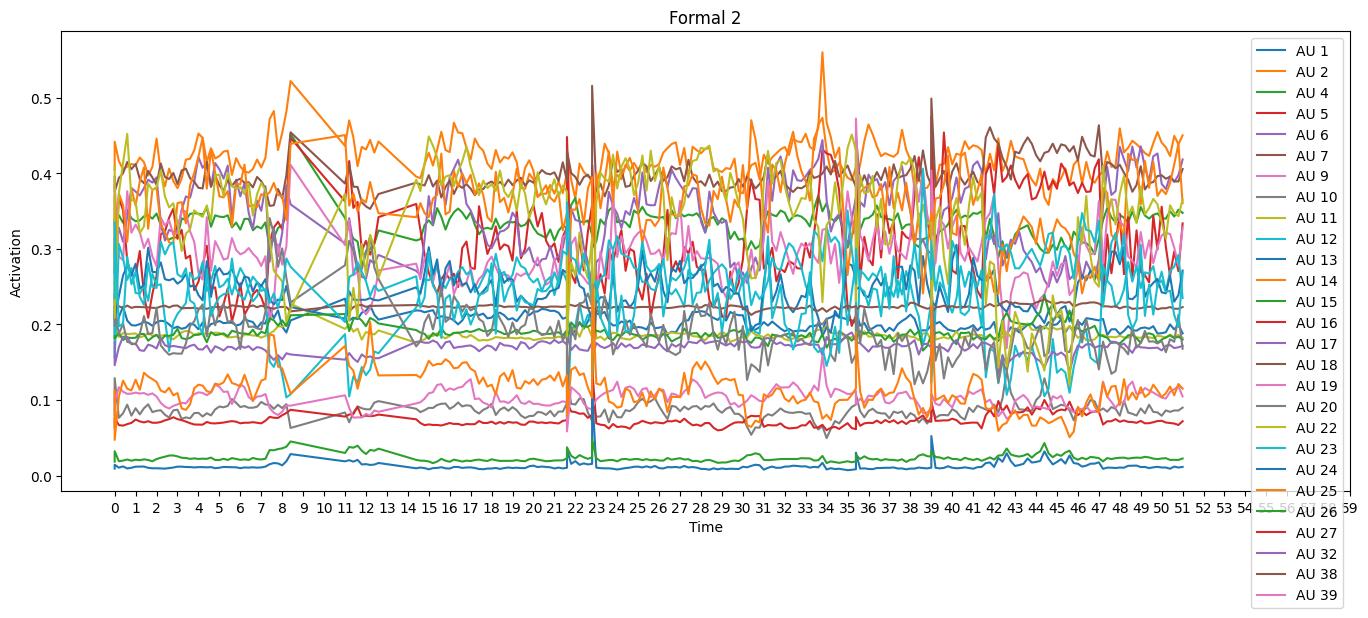

In [79]:
# Plot the activation of each action unit over time
# action units should be all plotted in the same graph

def plot_activation(df, title):
    fig, ax = plt.subplots()
    for i in range(n_au):
        # use au_ref to get the correct action unit
        au = df[df['face_au'] == au_ref[i]]
        ax.plot(au['time'], au['value'], label=f'AU {au_ref[i]}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Activation')
    ax.set_title(title)
    ax.legend()
    ax.set_xticks(np.arange(0, 60, 1))
    fig.tight_layout()
    fig.set_size_inches(15, 10)
    plt.show()
    

plot_activation(features_1, 'Formal 1')
plot_activation(features_2, 'Formal 2')

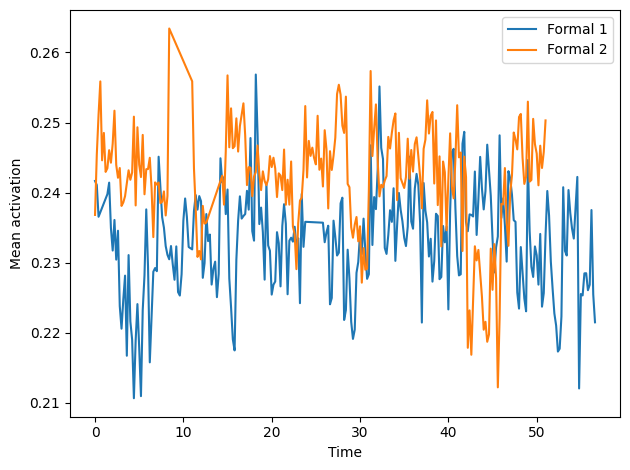

In [80]:
# Calculate the mean activation of each action unit for each time window
# and plot the mean activation of each action unit over time

def mean_activation_time(df):
    mean = df.groupby('time')['value'].mean()
    return mean

mean_time_1 = mean_activation_time(features_1)
mean_time_2 = mean_activation_time(features_2)

fig, ax = plt.subplots()
ax.plot(mean_time_1.index, mean_time_1.values, label='Formal 1')
ax.plot(mean_time_2.index, mean_time_2.values, label='Formal 2')

ax.set_xlabel('Time')
ax.set_ylabel('Mean activation')
ax.legend()

fig.tight_layout()

plt.show()

In [81]:
features_1.head()

,time,frame,face_au,value
0,0.0,0,0,0.243907
1,0.0,0,1,0.214739
2,0.0,0,2,0.388495
3,0.0,0,3,0.327955
4,0.0,0,4,0.298780


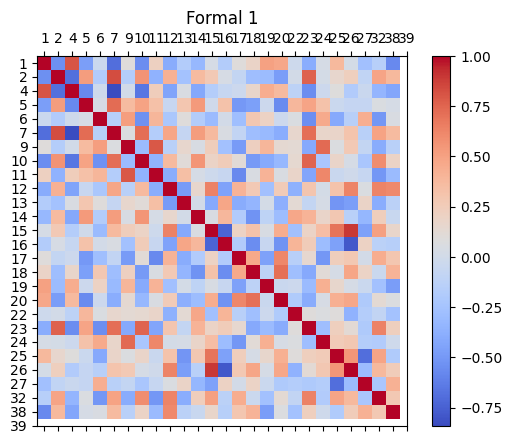

face_au  face_au
16       27         0.895321
27       16         0.895321
2        5          0.813073
5        2          0.813073
10       12         0.795285
dtype: float64

face_au  face_au
9        5         -0.838967
17       27        -0.785180
         16        -0.732185
9        2         -0.693318
4        5         -0.681071
dtype: float64

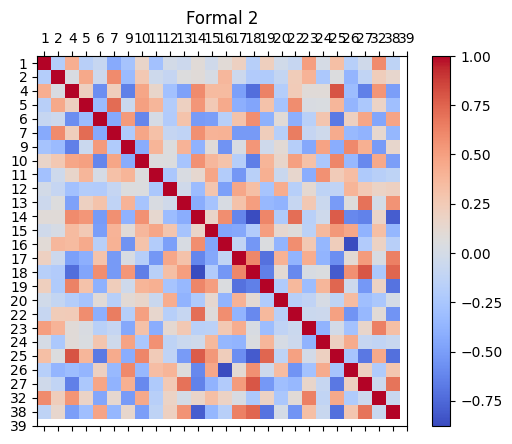

face_au  face_au
26       5          0.804191
         20         0.739449
15       23         0.708700
32       14         0.699011
9        23         0.650509
dtype: float64

face_au  face_au
17       27        -0.869279
19       5         -0.728073
20       18        -0.712228
18       20        -0.712228
39       20        -0.700223
dtype: float64

In [82]:
# Calculate the correlation between the action units of the first video

# First we need to convert the action units to columns in the dataframe
def pivot_au(df):
    # remove the time and frame columns
    pivoted = df.pivot_table(index='time', columns='face_au', values='value')
    return pivoted.drop(columns=[0])

pivoted_1 = pivot_au(features_1)
pivoted_2 = pivot_au(features_2)

# handle missing values
pivoted_1 = pivoted_1.fillna(0)
pivoted_2 = pivoted_2.fillna(0)

# Then we can calculate the correlation
correlation_1 = pivoted_1.corr()
correlation_2 = pivoted_2.corr()

def plot_correlation(correlation, title):
    fig, ax = plt.subplots()
    cax = ax.matshow(correlation, cmap='coolwarm')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(n_au))
    ax.set_yticks(np.arange(n_au))
    ax.set_xticklabels(au_ref)
    ax.set_yticklabels(au_ref)
    ax.set_title(title)
    plt.show()

# Print out the action units that are most correlated
def most_correlated(correlation):
    # map the action units to the reference ids
    correlation.columns = correlation.columns.map(lambda x: au_ref[x])
    correlation.index = correlation.index.map(lambda x: au_ref[x])

    # Unstack the correlation matrix and sort the values in descending order
    au_correlation = correlation.unstack()

    # Remove duplicate pairs of action units
    au_correlation = au_correlation[::2]

    # Remove the correlation of an action unit with itself
    au_correlation = au_correlation[au_correlation.index.get_level_values(0) != au_correlation.index.get_level_values(1)]

    positive = au_correlation.sort_values(ascending=False)
    negative = au_correlation.sort_values(ascending=True)

    return positive, negative

plot_correlation(correlation_1, 'Formal 1')
positive_1, negative_1 = most_correlated(correlation_1)
display(positive_1.head())
display(negative_1.head())

plot_correlation(correlation_2, 'Formal 2')
positive_2, negative_2 = most_correlated(correlation_2)
display(positive_2.head())
display(negative_2.head())

/Users/tom/Documents/GitHub/TEDx-Emotion-Capture/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette score: 0.18055486327285336


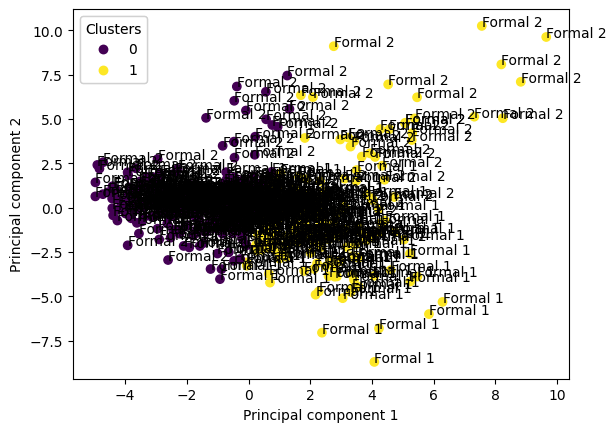

Silhouette score: 0.11206177426587777


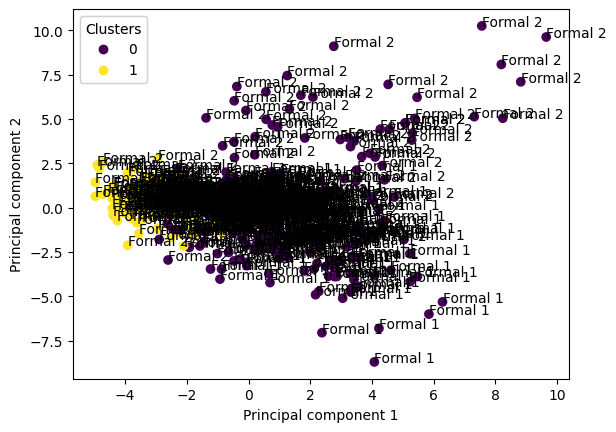

In [83]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# First we need to convert the action units to columns in the dataframe
# so that we can use them as features for the clustering

def pivot_au(df):
    pivoted = df.pivot_table(index='frame', columns='face_au', values='value')
    return pivoted

pivoted_1 = pivot_au(features_1)
pivoted_2 = pivot_au(features_2)

# concat the two dataframes with an multiindex
pivoted = pd.concat([pivoted_1, pivoted_2], keys=['Formal 1', 'Formal 2'])

# handle missing values
pivoted = pivoted.fillna(0)

# select the data that is part of the 99th percentile for each action unit
# pivoted = pivoted[pivoted > pivoted.quantile(0.99)]

# Standardize the data
scaler = StandardScaler()
pivoted_scaled = scaler.fit_transform(pivoted)

# Apply PCA to reduce the dimensionality
pca = PCA(n_components=2)
pivoted_pca = pca.fit_transform(pivoted_scaled)

# Apply k-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(pivoted_pca)
clusters = kmeans.predict(pivoted_pca)

# evaluate the clustering
silhouette = silhouette_score(pivoted_scaled, clusters)
print(f'Silhouette score: {silhouette}')

# Plot the clusters and label the points with the video they belong to

def plot_clusters(pivoted_pca, clusters, pivoted):
    fig, ax = plt.subplots()
    scatter = ax.scatter(pivoted_pca[:, 0], pivoted_pca[:, 1], c=clusters, cmap='viridis')
    legend = ax.legend(*scatter.legend_elements(), title='Clusters')
    ax.add_artist(legend)
    for i, txt in enumerate(pivoted.index.get_level_values(0)):
        ax.annotate(txt, (pivoted_pca[i, 0], pivoted_pca[i, 1]))
    ax.set_xlabel('Principal component 1')
    ax.set_ylabel('Principal component 2')
    plt.show()

plot_clusters(pivoted_pca, clusters, pivoted)

# lets try hierarchical clustering
from sklearn.cluster import AgglomerativeClustering

# Apply hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=2)
clusters = hierarchical.fit_predict(pivoted_scaled)

# evaluate the clustering
silhouette = silhouette_score(pivoted_scaled, clusters)
print(f'Silhouette score: {silhouette}')

plot_clusters(pivoted_pca, clusters, pivoted)